In [40]:
import numpy as np
import matplotlib.pyplot as plt

In [41]:
data = np.load('C:/Users/Lorenzo/Documents/Lubiana/Nnst/Data/camera11.npy')
signal = data[:,30,35]
nsec = 0.005
sampling_freq = 400
overlap = 0 
confidence = 95
plot_res = True

In [42]:
## Window length control
#if nsec >= 2/sampling_freq:
        

## Signal properties
N = len(signal)             #Number of points
dt = 1/sampling_freq        #Time step
T = N*dt - dt               #Time length
time = np.linspace(0, T, N) #Time vector

ent_std = np.std(signal, ddof = 1) #Standard deviation of entire signal
ent_mean = np.mean(signal)         #Mean value of entire signal

## Confidence interval
coeff = [1.645, 1.96, 2.326, 2.576]
conf = [90, 95, 98, 99]
alpha = coeff[conf.index(confidence)]

## Segments
wdw_pts = int(np.floor(sampling_freq * nsec))        #Number of point for each window
seg_pts = wdw_pts - int(np.floor(wdw_pts * overlap)) #Number of point for each segment (considering overlap)
seg = int(np.ceil(N / seg_pts))                      #Number of segments
seg_time = np.linspace(0,T,seg)
cls = np.array(np.array_split(signal, seg))          #Cluster (segmentation of signal)


In [43]:
## Boundaries
seg_std = np.std(cls, axis=1, ddof=1)
cls_std = np.std(seg_std, ddof = 1)
boundUP = ent_std + cls_std
boundDW = ent_std - cls_std

In [44]:
## Run computation
run = np.empty(seg)
for i in range(0, seg):
    if seg_std[i] > boundUP or seg_std[i] < boundDW:
        run[i] = 1
    else:
        run[i] = 0

N1 = 0
N0 = 0
for i in range(0, seg):
    if run[i] == 1.:
        N1 += 1
    else:
        N0 += 1
        
N = N1 + N0
Nr = 0

for i in range(1, seg):
    if run[i] != run[i-1]:
        Nr += 1

In [45]:
## Stationary limits 
run_mean = (2 * N1 * N0) / N + 1
run_var = (2 * N1 * N0 * (2 * N1 * N0 - N)) / (N**2 * (N - 1))

lim_up = run_mean + alpha * np.sqrt(run_var)
lim_dw = run_mean - alpha * np.sqrt(run_var)

index_up = np.round(100 * lim_up / run_mean, 2)
index_dw = np.round(100 * lim_dw / run_mean, 2)

if Nr >= lim_dw and Nr <= lim_up:   
    bns = 'Stationary'
else:
    bns = 'Non-stationary' 
    
## Index of non-stationary
index = np.round( 100 * Nr / run_mean, 2)
    
nnst = {'index': index, 'bns':bns, 'ind_dw':index_dw, 'ind_up':index_up}


In [46]:
nnst

{'index': 97.96, 'bns': 'Stationary', 'ind_dw': 96.9, 'ind_up': 103.1}

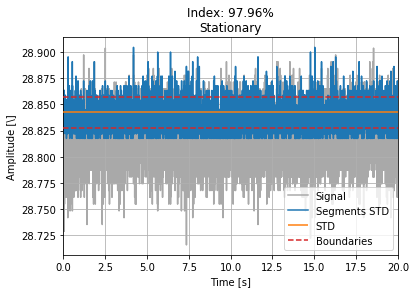

In [51]:
if plot_res == True:
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.grid(zorder = 0)
    ax.plot(time, signal, color = 'darkgray', zorder = 1, label = 'Signal')
    ax.plot(seg_time, ent_mean + seg_std, color = 'C0', zorder = 2, label = 'Segments STD')
    ax.hlines(ent_mean + ent_std, 0, T+dt, colors='C1', linestyles='solid', zorder = 3, label = 'STD')
    ax.hlines(ent_mean + boundUP, 0, T+dt, colors='C3', linestyles='dashed', zorder = 4, label = 'Boundaries')
    ax.hlines(ent_mean + boundDW, 0, T+dt, colors='C3', linestyles='dashed', zorder = 5)
    ax.legend(loc=4)
    ax.set_xlim([0,T+dt])
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Amplitude [\]')
    ax.set_title('Index: '+str(index) + '%\n' + bns)